<a href="https://colab.research.google.com/github/Tan-Yu/BirD/blob/main/GWU_NN_Project_To_Be_Submitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection: Furniture

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7qWbVQEyrrOmqn5a34Ik")
project = rf.workspace("roboflow-100").project("furniture-ngpea")
dataset = project.version(2).download("tensorflow")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
    Found existing

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to furniture-2 in tensorflow:: 100%|██████████| 697/697 [00:00<00:00, 2076.14it/s]


# Import Libraries

In [5]:
import cv2
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Add, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import ExponentialDecay



# Data Preparation

In [2]:


# Set the path to your dataset
data_path = "/content/furniture-2"

# Load annotations from CSV files
train_annotations = pd.read_csv(os.path.join(data_path, "train", "_annotations.csv"))
valid_annotations = pd.read_csv(os.path.join(data_path, "valid", "_annotations.csv"))

# Rescale bounding box coordinates based on the new image size
def rescale_bbox(row):
    width_ratio = 300 / row['width']
    height_ratio = 300 / row['height']
    row['xmin'] *= width_ratio
    row['xmax'] *= width_ratio
    row['ymin'] *= height_ratio
    row['ymax'] *= height_ratio
    return row

train_annotations = train_annotations.apply(rescale_bbox, axis=1)
valid_annotations = valid_annotations.apply(rescale_bbox, axis=1)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)

# Create custom data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_annotations,
    directory=os.path.join(data_path, "train"),
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(300, 300),
    batch_size=32,
    class_mode="raw",
    # subset="training"
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_annotations,
    directory=os.path.join(data_path, "valid"),
    x_col="filename",
    y_col=["xmin", "ymin", "xmax", "ymax"],
    target_size=(300, 300),
    batch_size=32,
    class_mode="raw",
    # subset="validation"
)


Found 454 validated image filenames.
Found 161 validated image filenames.




---



# Model \#1

##1. Input Layer:

* Input shape: (300, 300, 3) representing a 300x300 pixel image with 3 color channels (RGB).

##2. Convolutional Layers:

* Conv2D(64, (3, 3), activation='relu'): 64 filters of size 3x3, ReLU activation.

* MaxPooling2D((2, 2)): Max pooling with a 2x2 pool size to down-sample the spatial dimensions.

* Dropout(0.25): Regularization layer to prevent overfitting.

* Conv2D(128, (3, 3), activation='relu'): 128 filters of size 3x3, ReLU activation.

* MaxPooling2D((2, 2)): Max pooling for down-sampling.

* Conv2D(256, (3, 3), activation='relu'): 256 filters of size 3x3, ReLU activation.

* MaxPooling2D((2, 2)): Max pooling for down-sampling.

##3. Flatten Layer:

Flattens the output from the previous layers into a 1D array to be fed into dense layers.

##4. Fully Connected (Dense) Layers:

Dense(512, activation='relu'): 512 neurons with ReLU activation.
Dropout(0.5): Another dropout layer for regularization to further prevent overfitting.

##5. Output Layer:

Dense(4, activation='linear'): Output layer with 4 neurons corresponding to bounding box coordinates (xmin, ymin, xmax, ymax) for regression. Linear activation is used since this is a regression task.

## Key Points:

*   Convolutional layers extract hierarchical features from the input image.
*   Max pooling layers down-sample the spatial dimensions.
* Dropout layers help prevent overfitting.
* The final dense layers map the extracted features to bounding box coordinates.
* Smooth L1 loss is typically used for regression tasks like bounding box prediction.






In [34]:

# Define and compile the model with smooth L1 loss
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='linear')
])

# Model #2

Similar to YOLO



In [45]:

# Define input layer
input_layer = Input(shape=(300, 300, 3))

# Feature extraction backbone
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(512, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# Global average pooling layer
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for bounding box regression
output_layer = Dense(4, activation='linear')(x)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)


# Model \#3: Batch Normalization, and Regularization

In [52]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='linear')
])



# Model #4

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='linear')  # Output layer with 4 neurons for bounding box coordinates
])

# Model #5

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),  # Additional dense layer
    Dense(128, activation='relu'),  # Additional dense layer
    Dense(64, activation='relu'),   # Additional dense layer
    Dense(4, activation='linear')   # Output layer with 4 neurons for bounding box coordinates
])

# Compile Model \#1: Huber Loss




In [7]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber_loss', metrics=['accuracy'])



# Compile Model \#2: ExponentialDecay


In [14]:
# Learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9, staircase=True
)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='huber_loss', metrics=['accuracy'])


# Check Model Info

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 149, 149, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 341056)            0         
                                                                 
 dense_4 (Dense)             (None, 256)              

# Hyperparameters

In [16]:
# Set up early stopping and learning rate schedule
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


# Training Model

In [17]:
# Train the model with early stopping and learning rate schedule
history = model.fit(train_generator, validation_data=valid_generator, epochs=60, callbacks=[early_stopping, reduce_lr])


Epoch 1/60
15/15 [==============================] - 8s 429ms/step - loss: 71.5700 - accuracy: 0.4648 - val_loss: 53.8664 - val_accuracy: 0.8012 - lr: 0.0010
Epoch 2/60
15/15 [==============================] - 5s 359ms/step - loss: 39.1003 - accuracy: 0.5396 - val_loss: 35.7615 - val_accuracy: 0.2360 - lr: 0.0010
Epoch 3/60
15/15 [==============================] - 7s 467ms/step - loss: 32.2281 - accuracy: 0.7467 - val_loss: 31.3997 - val_accuracy: 0.7453 - lr: 0.0010
Epoch 4/60
15/15 [==============================] - 7s 437ms/step - loss: 25.4673 - accuracy: 0.8194 - val_loss: 22.6259 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 5/60
15/15 [==============================] - 6s 386ms/step - loss: 21.9168 - accuracy: 0.8700 - val_loss: 21.2584 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 6/60
15/15 [==============================] - 6s 414ms/step - loss: 18.4719 - accuracy: 0.8965 - val_loss: 18.4638 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 7/60
15/15 [==============================] - 5s 352

# Evaluate Neural Network

1/1 [==============================] - 0s 90ms/step
TRUE [88.25, 109.25, 273.5, 258.75]
PRED [ 49.561634 112.57122  265.79178  277.59863 ]


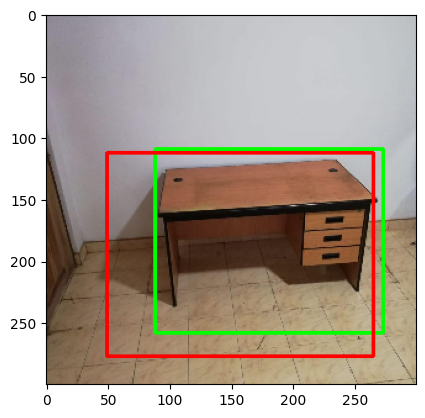

1/1 [==============================] - 0s 19ms/step
TRUE [67.25, 160.25, 256.25, 276.0]
PRED [ 76.44001 105.82451 244.74841 306.97894]


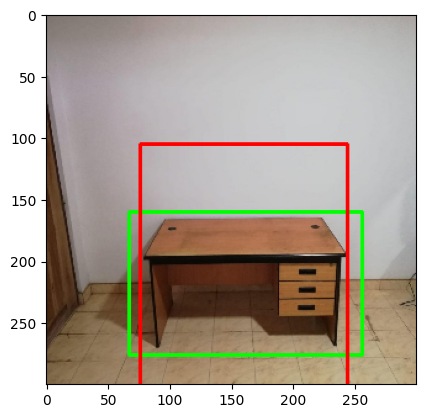

1/1 [==============================] - 0s 23ms/step
TRUE [6.0, 36.5, 294.5, 252.5]
PRED [-29.449198  34.42807  290.12634  232.61273 ]


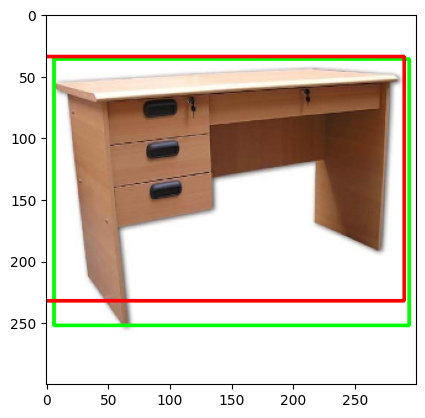

1/1 [==============================] - 0s 19ms/step
TRUE [0.75, 83.5, 299.5, 215.25]
PRED [-20.212114 105.11714  317.534    240.81927 ]


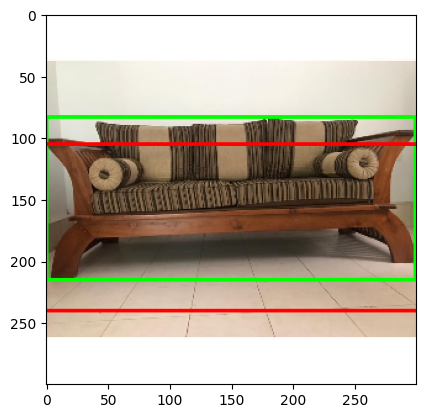

1/1 [==============================] - 0s 18ms/step
TRUE [34.5, 94.75, 257.25, 245.5]
PRED [  6.631098 117.80938  337.8562   275.71808 ]


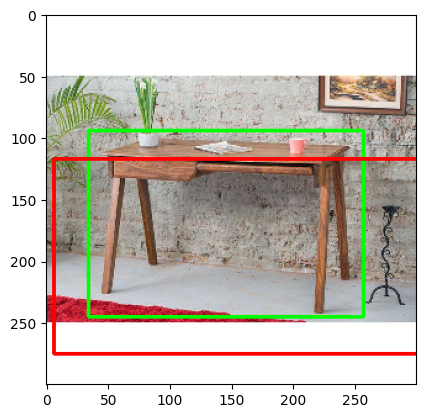

1/1 [==============================] - 0s 28ms/step
TRUE [5.5, 111.25, 286.0, 236.25]
PRED [ -3.8812354 119.54554   328.14044   263.53705  ]


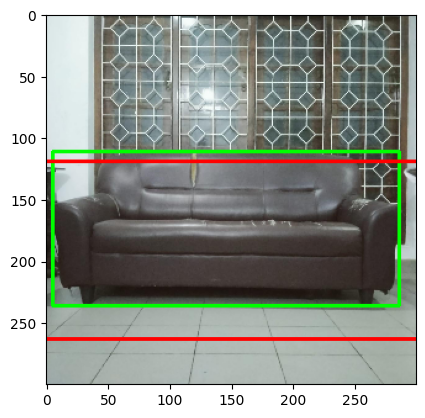

1/1 [==============================] - 0s 22ms/step
TRUE [6.0, 81.0, 288.25, 288.25]
PRED [  3.6107767 106.57138   294.76736   252.49277  ]


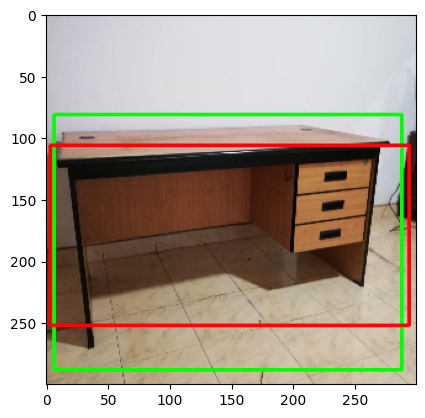

1/1 [==============================] - 0s 19ms/step
TRUE [4.5, 64.25, 299.25, 230.0]
PRED [-14.766256  80.20136  313.358    257.52408 ]


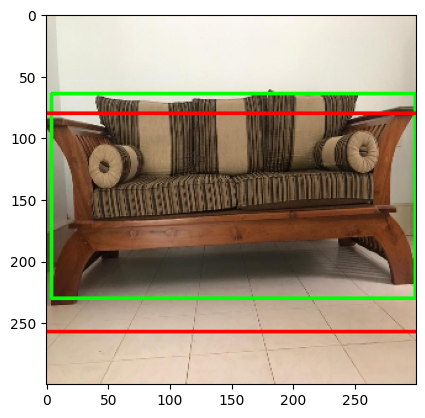

1/1 [==============================] - 0s 27ms/step
TRUE [12.25, 54.25, 278.25, 243.0]
PRED [-33.282413  52.429108 303.71454  247.77011 ]


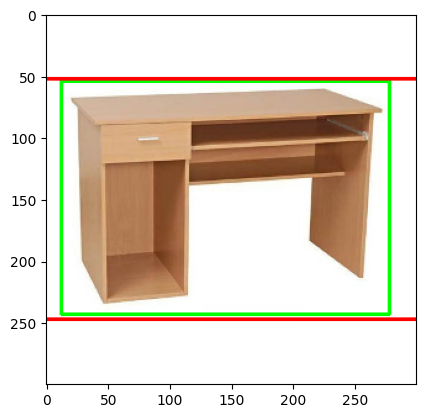

1/1 [==============================] - 0s 20ms/step
TRUE [26.25, 83.0, 272.75, 273.75]
PRED [ 19.767282 107.84394  303.23044  277.43594 ]


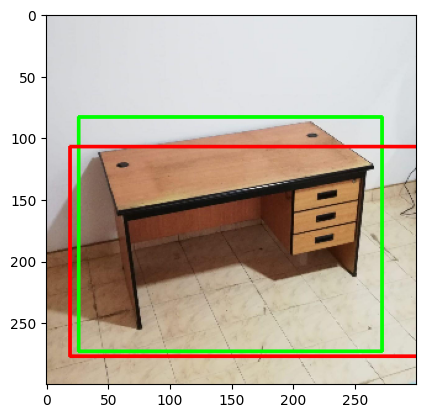

In [12]:
def plot_bounding_boxes(image_array, true_bbox, pred_bbox):
    # Convert image array to uint8 for compatibility with OpenCV
    img = (image_array * 255).astype(np.uint8)

    # True bounding box
    true_xmin, true_ymin, true_xmax, true_ymax = true_bbox
    cv2.rectangle(img, (int(true_xmin), int(true_ymin)), (int(true_xmax), int(true_ymax)), (0, 255, 0), 2)

    # Predicted bounding box
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox
    cv2.rectangle(img, (int(pred_xmin), int(pred_ymin)), (int(pred_xmax), int(pred_ymax)), (255, 0, 0), 2)

    # Invert the y-axis
    # img = cv2.flip(img, 0)

    plt.imshow(img)
    plt.show()

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0  # Normalize the pixel values to [0, 1]


i = 0
for index, row in valid_annotations.iterrows():
    if i == 10:
        break

    image_path = os.path.join(data_path, 'valid', row['filename'])
    true_bbox = [row['xmin'], row['ymin'], row['xmax'], row['ymax']]

    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    # print(type(img_array))
    # Predict bounding box
    pred_bbox = model.predict(img_array)[0]

    print("TRUE", true_bbox)
    print("PRED", pred_bbox)

    # Plot true and predicted bounding boxes using img_array
    plot_bounding_boxes(img_array[0], true_bbox, pred_bbox)


    i += 1



# Experiment Conclusion

After a few experiemnts with the following permutations, found that ____ works best:

1. Model #1 + Compile Model #1
2. Model #2 + Compile Model #1
3. Model #3 + Compile Model #1
4. Model #4 + Compile Model #1
5. Model #1 + Compile Model #2
6. Model #2 + Compile Model #2
7. Model #3 + Compile Model #2
8. Model #4 + Compile Model #2

## Concluded that permutation 8 (Model #4 + Compile Model #2) works best.

### In this permutation, we have the following techniques:

#### _Model Architecture:_

Conv2D Layer (32 filters, kernel size 3x3, ReLU activation):

The first Conv2D layer with 32 filters extracts 32 different features from the input image using a 3x3 kernel.
The ReLU (Rectified Linear Unit) activation function is applied element-wise, introducing non-linearity.
MaxPooling2D Layer (2x2 pooling size):

Max pooling reduces the spatial dimensions of the representation and retains the most important information.
The 2x2 pooling size means that the maximum value within each 2x2 region is retained, reducing the width and height by half.
Conv2D Layer (64 filters, kernel size 3x3, ReLU activation):

The second Conv2D layer with 64 filters extracts higher-level features from the already processed representation.
Again, ReLU introduces non-linearity.
MaxPooling2D Layer (2x2 pooling size):

Another max pooling layer further reduces the spatial dimensions.
Flatten Layer:

Flattens the 2D output from the previous layer into a 1D array. This prepares the data for input to the fully connected layers.
Dense Layer (128 neurons, ReLU activation):

A fully connected layer with 128 neurons. This layer learns global features from the flattened representation.
Dense Layer (4 neurons, linear activation):

The output layer with 4 neurons for bounding box regression. The linear activation allows the model to directly predict continuous values.
This architecture follows a common pattern for image processing tasks. Convolutional layers are responsible for feature extraction, max pooling reduces spatial dimensions, and dense layers learn global patterns. It's worth noting that more complex architectures, like those used in advanced object detection models (e.g., YOLO, Faster R-CNN), may include additional components like skip connections, anchor boxes, and multiple scales of feature maps to capture richer information. The given architecture is a good starting point, and you can experiment with more layers and parameters based on your specific task and dataset.


## _Hyperparameters:_


### **ExponentialDecay:**
ExponentialDecay is a learning rate schedule that exponentially decays the learning rate over time.

1. **initial_learning_rate**: The initial learning rate at the beginning of training (0.001 in this case).

2. **decay_steps**: The number of steps after which the learning rate will decay.
decay_rate: The factor by which the learning rate will decay. In this case, it's set to 0.9, meaning the learning rate will be multiplied by 0.9 after each decay_steps.

3. **staircase=True**: If True, the learning rate will decay at discrete intervals (steps).

### **Adam Optimizer with Dynamic Learning Rate:**

The Adam optimizeris used with a dynamic learning rate defined by the ExponentialDecay.
The learning rate of the optimizer is set to the lr_schedule defined above.
As training progresses, the learning rate will exponentially decay, allowing the model to fine-tune its parameters with a smaller learning rate over time.

### **Early Stopping:**

**Purpose**: Early stopping is a regularization technique used to prevent overfitting.

**How it works**: The training process monitors a specified metric (in this case, 'val_loss'), and if the metric stops improving for a certain number of epochs (defined by patience), the training is stopped early.

**Parameters**:
1. monitor: The metric to monitor (e.g., 'val_loss').

2. patience: The number of epochs with no improvement after which training will be stopped.

3. restore_best_weights: Restores the model weights from the epoch with the best value of the monitored metric.

### **Learning Rate Schedule with ReduceLROnPlateau:**

**Purpose:** Adjust the learning rate during training to improve convergence or prevent divergence.
**How it works**:  Monitors a specified metric (monitor, usually validation loss) and reduces the learning rate when the metric stops improving.
**Parameters:**
1. monitor: The metric to monitor (e.g., 'val_loss').
2. factor: Factor by which the learning rate will be reduced. New_lr = lr * factor.
3. patience: Number of epochs with no improvement after which the learning rate will be reduced.
min_lr: Lower bound on the learning rate.

In summary, if the validation loss does not improve for a certain number of epochs (patience), the learning rate is reduced by a factor of factor. This can help in fine-tuning the model's performance and preventing overshooting.

